# VGP-based APWP

 APWP based on recompiled VGPs

In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP, running_mean_APWP_shape, RM_stats
from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble

Path to the VGP directory.

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

## Generate a DataFrame for both, the VGPs and the recomputed poles by study

In doing so, we calculate a pole for each study taking into account all the vgps within the same area/study

In [3]:
df_filtered_vgps, df_pole_compilation_by_study = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True)

# Moving average on VGPs

In the present formulation the age of each VGP is taken as a deterministic value represented by the mean 
of the lower and upper bounds of the reported VGPs (`df_filtered_vgps['mean_age']`)

In [4]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10

RM_on_VGP = running_mean_APWP(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
RM_on_VGP

,age,N,n_studies,k,A95,csd,plon,plat
0,0.0,305.0,15.0,23.294563,1.704883,16.782542,317.083230,-87.945102
1,10.0,330.0,16.0,21.201852,1.721511,17.591307,327.300988,-87.482422
2,20.0,207.0,9.0,10.117603,3.239569,25.465148,341.959534,-82.115848
3,30.0,359.0,7.0,12.400810,2.196629,23.001703,336.344662,-82.377411
4,40.0,304.0,9.0,16.589316,2.042163,19.887069,336.936345,-82.580048
5,50.0,308.0,10.0,14.315533,2.195171,21.408255,352.288745,-82.359689
6,60.0,182.0,4.0,13.002846,3.012739,22.462899,358.639803,-81.942511


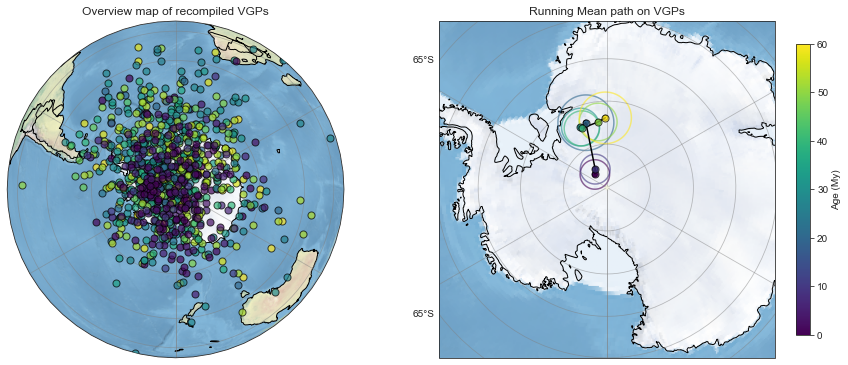

In [5]:
extent = [-180,180,-70,-70]
plot_VGPs_and_APWP(extent, df_filtered_vgps, RM_on_VGP)

### VGPs age distribution

<AxesSubplot:title={'center':'VGP age distribution'}, xlabel='Mean Age', ylabel='Number of VGPs'>

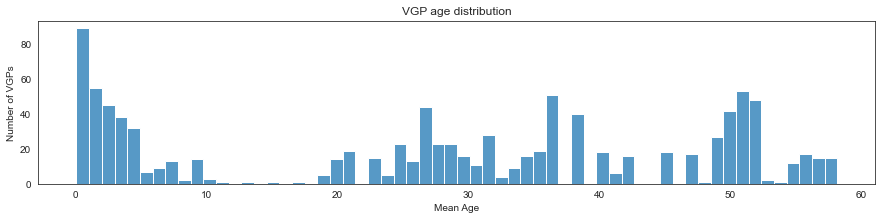

In [6]:
fig = plt.figure(figsize=(15,3))
plt.title('VGP age distribution')
plt.ylabel('Number of VGPs')
plt.xlabel('Mean Age')
sns.histplot(data = df_filtered_vgps, x = 'mean_age', bins = 60, legend = False)

### Running Mean Statistics

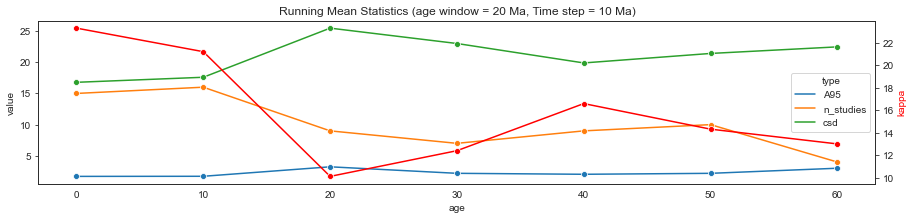

In [7]:
RM_stats(RM_on_VGP, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)","Age (Ma)","kappa")

# APWP confidence bounds

To generate confidence bounds on the APWP, we will sample with replacement the original dataset of VGPs a number of times in order to construct an ensemble of possible solutions that will allow us to construct empirical confidence bounds.

In [11]:
def running_mean_VGPs_bootstrapped(df_vgps, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age, n_bst = 100):
    '''
    takes a compilation of vgps and for each time window uses the bootstrap approach to construct empirical confidence bounds. 
    '''

    running_means_global = pd.DataFrame(columns=['run','N','k','A95','csd','foliation','lineation','collinearity','coplanarity'])

    for i in range(n_bst):
               
        vgps_sample = df_vgps.sample(n = len(df_vgps), replace = True)
        running_means_tmp = pd.DataFrame()
        running_means_tmp = running_mean_APWP_shape(vgps_sample, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age)
        running_means_tmp['run'] = float(i)
        running_means_global = running_means_global.append(running_means_tmp, ignore_index=True)
       
    return running_means_global

In [12]:
%%time
df_ensemble = running_mean_VGPs_bootstrapped(df_filtered_vgps, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window_length, time_step, max_age, min_age, n_bst = 200)

Wall time: 30.9 s


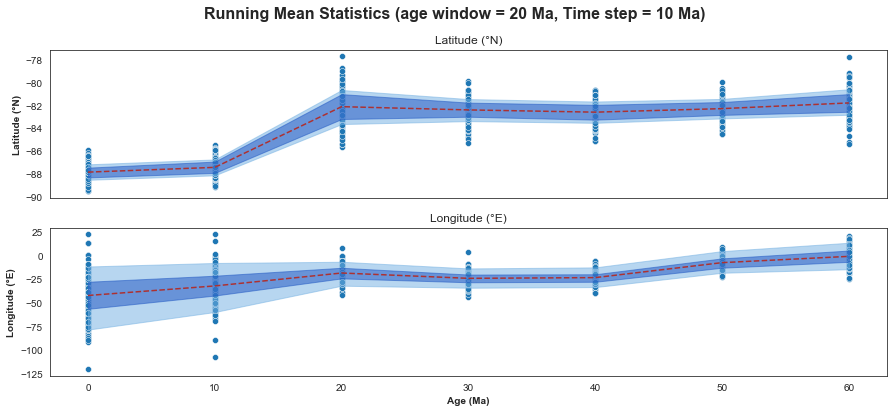

In [10]:
plot_APWP_RM_ensemble(df_ensemble, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)")